In [5]:
""" 
Import Libraries and create the preprocessing Function
"""
#Import libraries
import pytz
import numpy as np
import keras
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas_ta as ta
import MetaTrader5 as mt5
from datetime import datetime, timedelta, timezone
from sklearn.metrics import mean_absolute_error, r2_score, mean_absolute_percentage_error
from keras.models import load_model
from timedelta import Timedelta
import os

#print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
scaler = MinMaxScaler(feature_range=(0, 1))
def create_dataset(dataset, N=60):
    X, Y = [], []
    for i in range(len(dataset) - N):
        X.append(dataset[i:(i + N)])
        Y.append(dataset[i + N, -1])
    return np.array(X), np.array(Y)
# Apply the new function
N = 60
now = datetime.now(timezone.utc)

In [4]:
if mt5.initialize():
    # Replace with your login credentials
    mt5.login(login=52061328, server="ICMarketsSC-Demo", password="JZYado3C!D9NWL")

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 60, 40)            6720      
                                                                 
 dropout_3 (Dropout)         (None, 60, 40)            0         
                                                                 
 lstm_4 (LSTM)               (None, 60, 25)            6600      
                                                                 
 dropout_4 (Dropout)         (None, 60, 25)            0         
                                                                 
 lstm_5 (LSTM)               (None, 60, 20)            3680      
                                                                 
 dropout_5 (Dropout)         (None, 60, 20)            0         
                                                                 
 dense_1 (Dense)             (None, 60, 1)            

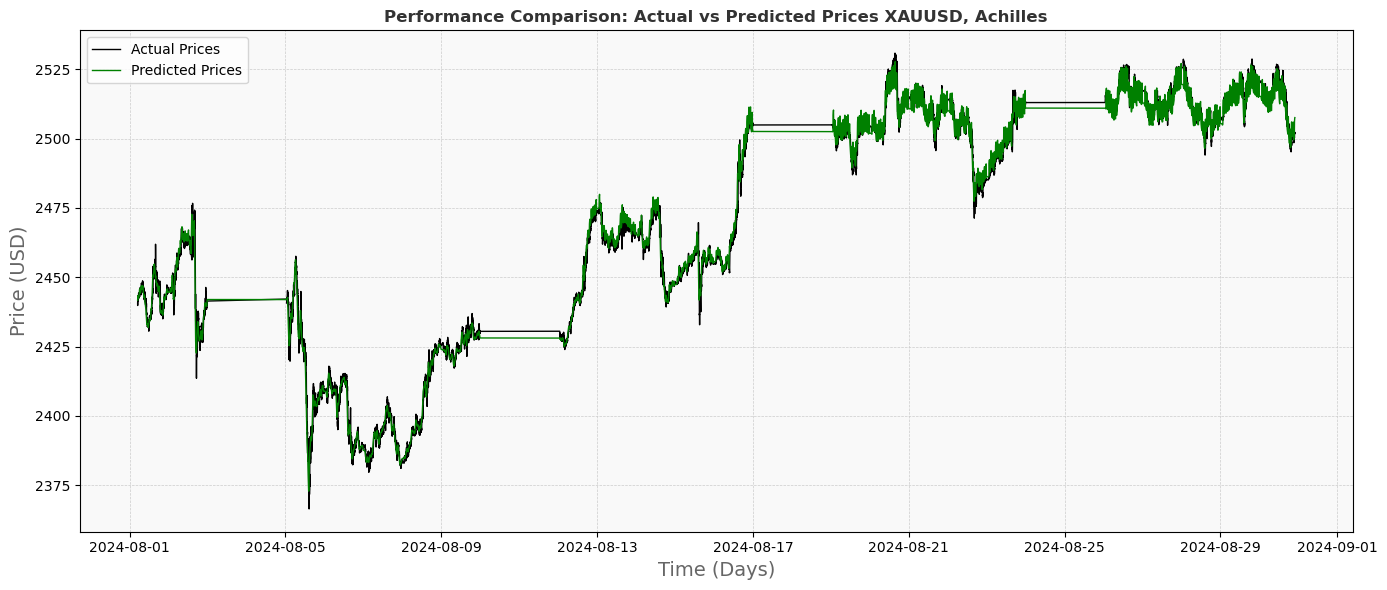

In [47]:
""" 
Test the model on previus Data and crate the Time
"""
import warnings
warnings.filterwarnings('ignore')
model = keras.models.load_model(r"C:\Users\Angel\OneDrive\Escritorio\Vs Code\Achilles\Achilles3.0.keras")
model.summary()
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

if mt5.initialize():
    # Replace with your login credentials
    mt5.login(login=51863590, server="ICMarketsSC-Demo", password="1lfz&CJ7jyX2N8")

# Get all symbols
all_symbols = mt5.symbols_get()
# Filter symbols related to NASDAQ
nasdaq_symbols = [symbol for symbol in all_symbols if 'NAS' in symbol.name]
symbol = 'XAUUSD'


#TO CHECK THE BEST ACCURACY IN NASDAK SYMBOLS
#sy = {}
# for symbol in nasdaq_symbols:
#     #CREATE A THE TEST DF
#     test = mt5.copy_rates_range(symbol.name, mt5.TIMEFRAME_M1, datetime(2024, 6, 1), now)
#     test = pd.DataFrame(test)
#     if test is None or len(test) == 0:
#         continue
    
#     test = pd.DataFrame(test)
#     if 'close' not in test.columns:
#         continue
    

#     test_1 = test['close'].tail(73368)
    
#     # Check if test_1 is empty
#     if test_1.empty:
#         continue
#     test_1 = test['close'].tail(73368)
#     test_scaled = scaler.fit_transform(np.array(test_1).reshape(-1, 1))
#     _, X_test = create_dataset(test_scaled, N)
#     _, y_test = create_dataset(test_scaled, N)
#     #RESHAPE FOR PREDICTIONS
#     elements_two = X_test.size
#     divisible_two = (elements_two // 60) * 60
#     X_predict_shape = X_test[:divisible_two]
#     X_test = X_predict_shape.reshape(-1, 60, 1)

#     elements_one = y_test.size
#     divisible_one = (elements_one // 60) * 60
#     y_predict_shape = y_test[:divisible_one]
#     y_test = y_predict_shape.reshape(-1, 60, 1)

#     y_pred = model.predict(X_test)
#     # Inverse scaling
#     y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))
#     y_real = scaler.inverse_transform(y_test.reshape(-1, 1))
#     min_length = min(len(y_real), len(y_pred))
#     y_real = y_real[:min_length]
#     y_pred =y_pred[:min_length]
#     r = r2_score(y_true=y_real, y_pred=y_pred)
#     sy[symbol.name] = r

#now = datetime(2024, 12, 15)  #datetime.now(timezone.utc) + Timedelta(hours=2)
time = timedelta(hours=5)
start = datetime(2024, 8, 1) #CHANGE DINAMICALLY DEPENDING ON THE WEEK YOU WANT TO PREDICT
end = datetime(2024, 9, 1) #CHANGE DINAMICALLY DEPENDING ON THE WEEK YOU WANT TO PREDICT
now = datetime.now(timezone.utc) + time
test = mt5.copy_rates_range(symbol, mt5.TIMEFRAME_M1, start, end)
test = pd.DataFrame(test)
date = pd.to_datetime(test['time'], unit='s', utc=True)

test_1 = test['close'] #.tail(21600) 

test_scaled = scaler.fit_transform(np.array(test_1).reshape(-1, 1))
print("This needs to be near to 21600, (Three weeks to predict the next one)", len(test_scaled))

_, X_test = create_dataset(test_scaled, N)
_, y_test = create_dataset(test_scaled, N)


#RESHAPE FOR PREDICTIONS
elements_two = X_test.size
divisible_two = (elements_two // 60) * 60
X_predict_shape = X_test[:divisible_two]
X_test = X_predict_shape.reshape(-1, 60, 1)

elements_one = y_test.size
divisible_one = (elements_one // 60) * 60
y_predict_shape = y_test[:divisible_one]
y_test = y_predict_shape.reshape(-1, 60, 1)

#Prepare the test data
y_pred = model.predict(X_test)
#y_pred = y_pred[:, 0]
# Inverse scaling
y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))
y_real = scaler.inverse_transform(y_test.reshape(-1, 1))

# Apply moving average to smooth the predicted prices
window_size = 40  # Adjust the window size as needed
y_pred_smooth = np.convolve(y_pred.flatten(), np.ones(window_size)/window_size, mode='valid')

"""
DEFINE THE TIMEFRAME DF
"""

#TIME DF FOR NORMAL SYMBOLS
hours = timedelta(hours=7)
now = datetime.now() + hours
sixty_days = now + timedelta(days=7) #ADJUST THE DAYS
sixty_days = sixty_days.replace(microsecond=0)
date_range = pd.date_range(start=now.replace(microsecond=0), end=sixty_days, freq='1min')
date_range = date_range[date_range.dayofweek < 5]
time_df = pd.DataFrame(date_range)
time_df[0] = time_df[0].apply(lambda x: x.strftime('%Y-%m-%d %H:%M:%S'))
rows_time_df = len(time_df)
print(f"Needs to be 7200: {(rows_time_df)}")

#TIME DF FOR CRYPTO SYMBOLS
# now = datetime.now(timezone.utc) + timedelta(hours=2)

# sixty_days = now + timedelta(days=7)
# sixty_days = sixty_days.replace(microsecond=0)
# date_range = pd.date_range(start=date, end=sixty_days, freq='1min')
# time_df = pd.DataFrame(date_range)
# time_df[0] = time_df[0].apply(lambda x: x.strftime('%Y-%m-%d %H:%M:%S'))
# rows_time_df = len(time_df)
# print(f"Number of rows: {(rows_time_df)}")
# print(now)

#TIME DF FOR NASDAQ SYMBOLS
# now = datetime.now()
# end_time = now + timedelta(weeks=2)
# timestamps = []
# Loop through each day in the range
# current_time = now
# while current_time < end_time:
#     if current_time.weekday() < 5:  # Exclude Saturdays and Sundays
#         # Add minute-per-minute timestamps from 16:35 to 22:35
#         daily_start = current_time.replace(hour=16, minute=35, second=0, microsecond=0)
#         daily_end = current_time.replace(hour=22, minute=55, second=0, microsecond=0)
#         while daily_start <= daily_end:
#             timestamps.append(daily_start)
#             daily_start += timedelta(minutes=1)
#     current_time += timedelta(days=1)
# time_df = pd.DataFrame(timestamps, columns=["Timestamps"])
# rows_time_df = len(time_df)
# print(f"Number of rows: {(rows_time_df)}")

min_length = min(len(y_real), len(y_pred_smooth), len(date))
y_real = y_real[:min_length]
y_pred_smooth =y_pred_smooth[:min_length]
date = date[:min_length]
print(f"MAE Score {mean_absolute_error(y_true=y_real, y_pred=y_pred_smooth)}")
print(f"MAPE Score {mean_absolute_percentage_error(y_true=y_real, y_pred=y_pred_smooth)}")
print(f"R2 Score (Accuracy) {r2_score(y_true=y_real, y_pred=y_pred_smooth)}")


# Plot the results
plt.figure(figsize=(14, 6))
plt.plot(date, y_real, label='Actual Prices', color='black', linewidth=1.0)
plt.plot(date, y_pred_smooth, label='Predicted Prices', color='green', linewidth=1.0)
# Enhance axis aesthetics
plt.xlabel('Time (Days)', fontsize=14, color='#666666')
plt.ylabel('Price (USD)', fontsize=14, color='#666666')
plt.title(f'Performance Comparison: Actual vs Predicted Prices {symbol}, Achilles', fontweight='bold', color='#333333')
plt.grid(visible=True, linestyle='--', linewidth=0.5, color='#cccccc')
plt.legend()
plt.gca().set_facecolor('#f9f9f9')
plt.tight_layout()
plt.show()
plt.show()

In [5]:
def predict(batch_size, M, R, timestamps):
    window_data = X_test[-R:] 
    predictions = []
    for i in range(M):
        prediction = model.predict(window_data.reshape(-1, N, 1), batch_size= batch_size, verbose=0)  # Reshape for LSTM
        predictions.append(prediction[0, 0])  
        window_data = np.roll(window_data, -timestamps)  # Shift data by one time step
        window_data[-timestamps] = prediction[0, 0]  # Update last value with prediction
        if len(prediction) > M:
            break
    #q = np.array(predictions).reshape(-1, 1)
    predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))
    return predictions

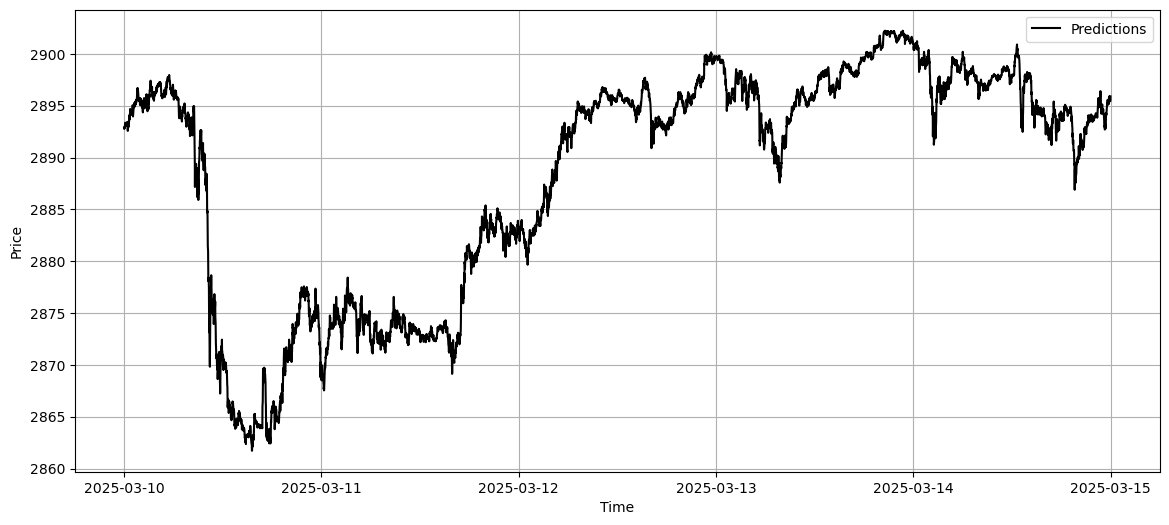

In [6]:
""" 
Make Predictions to the Future
"""

batch_size = 60
M = rows_time_df #OPTIMIZED
R = 21000 #OPTIMIZED
timestamps = 1 #OPTIMIZED
predictions = []
window_data = X_test[-R:] 
for i in range(M):
    prediction = model.predict(window_data.reshape(-1, N, 1), batch_size= batch_size, verbose=0)  # Reshape for LSTM
    predictions.append(prediction[0, 0])  
    window_data = np.roll(window_data, -timestamps)  # Shift data by one time step
    window_data[-timestamps] = prediction[0, 0]  # Update last value with prediction
    if len(prediction) > M:
        break
predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

predictions_df = pd.DataFrame(predictions, columns=['Predictions'])
time_df.columns = ['Time']
predictions_df['Time'] = time_df['Time']
predictions_df['Time'] = pd.to_datetime(predictions_df['Time'])

# Plot the predictions with time
if np.isnan(predictions).sum() == 0:
    plt.figure(figsize=(14, 6))
    plt.plot(predictions_df['Time'], predictions_df['Predictions'], color='black', label='Predictions')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.grid(True)
    plt.legend()
    plt.show()
else:
    print("Predictions contain NaN values.")

In [ ]:
"""
Save the DataFrame
"""
stock_prices_df = pd.DataFrame(predictions)
minutes_predicted = len(predictions)
min_length = min(len(time_df), len(stock_prices_df))
time_df = time_df[:min_length]
stock_prices_df = stock_prices_df[:min_length]
#Create a new full dataframe to be used in our trading bot.
full_df = pd.concat([time_df, stock_prices_df], axis='columns')
full_df = full_df.reset_index().drop_duplicates(subset='index', keep='last').set_index('index')
full_df.columns = ['Date', 'Price']
full_df['Price'] = full_df['Price'].astype(float).round(8)
 
#Save the dataframe
full_df.to_csv("XAUUSD.csv", index=False) 
print(full_df.duplicated)

In [ ]:
"""
Optional to Compare the predicted DataFrame vs the Real DataFrame
"""

# if mt5.initialize():
#     # Replace with your login credentials
#     mt5.login(login="login", server="Server", password="Password")

# columns_names = ("Date", "Price")
# dataframe = pd.read_csv(r"C:\Users\Angel\OneDrive\Escritorio\Vs Code\Achilles\XAUUSD.csv", names=columns_names, skiprows=1)
# data = pd.DataFrame(dataframe)
# data["Date"] = pd.to_datetime(data["Date"], format='%Y-%m-%d %H:%M:%S')


# y = mt5.copy_rates_range(symbol, mt5.TIMEFRAME_M1, datetime(2024, 12, 23, 1), now)
# df_y = pd.DataFrame(y)
# df_y['time'] = pd.to_datetime(df_y["time"], unit='s')
# df_y = df_y['close']

# s_date = '2024-11-25 00:00:14'
# e_date = pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')
# data_range = pd.date_range(start=s_date, end=e_date, freq='1min')
# rows = len(data_range)
# print(len(data_range))

# df_x = data.head(14401)
# df_x = df_x.loc[(df_x['Date'] >= s_date) & (df_x['Date'] <= e_date)]
# df_x = df_x['Price']
# min_length = min(len(df_y), len(df_x))
# df_y = df_y[:min_length]
# df_x = df_x[:min_length]
# print(len(df_x))
# print(len(df_y))


# # Create visualization
# plt.style.use('dark_background')
# plt.figure(figsize=(20, 10))
# #plt.plot(df_y, label='Prices', color='black')
# plt.plot(df_x, label='Predictions', color='#00ff00')
# plt.xlabel('Time')
# plt.ylabel('Price')
# plt.title('Actual vs. Predicted Prices')
# plt.grid(True)
# plt.legend()
# plt.show()

# plt.figure(figsize=(20, 10))
# plt.plot(df_y, label='Prices', color='#ff9900')
# #plt.plot(df_x, label='Predicted Prices', color='sienna')
# plt.xlabel('Time')
# plt.ylabel('Price')
# plt.title('Actual vs. Predicted Prices')
# plt.grid(True)
# plt.legend()
# plt.show()
# print(f"Mean Squeared Absolute Error: {np.sqrt(mean_absolute_error(y_true=df_y, y_pred=df_x))}")
# print(f"R2 Score: {r2_score(y_true=df_y, y_pred=df_x)}")